# Exp 3 analysis

See `./informercial/Makefile` for experimental
details.

In [1]:
import os
import numpy as np

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from infomercial.exp import meta_bandit
from infomercial.local_gym import bandit
from infomercial.exp.meta_bandit import load_checkpoint
import gym

In [2]:
# ls ../data/exp2*

# Load and process data

In [3]:
data_path ="/Users/qualia/Code/infomercial/data/"
exp_name = "exp3"
num_exps = 50
num_episodes = 10000
env_names = [
    "BanditOneHigh2-v0",
    "BanditOneHigh10-v0",
    "BanditOneHigh121-v0",
    "BanditOneHigh1000-v0",
    "BanditHardAndSparse2-v0",
    "BanditHardAndSparse10-v0",
    "BanditHardAndSparse121-v0", 
    "BanditHardAndSparse1000-v0"
]

In [4]:
# Gather traces by bandit: scores, Qs in a big numpy array (n_exp, n_episodes)
scores_E = {}
scores_R = {}
values_E = {}
values_R = {}
controlling = {}
actions = {}
best = {}

for env in env_names:
    # Preallocate the arrays for this env
    scores_E[env] = np.zeros((num_episodes, num_exps))
    scores_R[env] = np.zeros((num_episodes, num_exps))
    values_E[env] = np.zeros((num_episodes, num_exps))
    values_R[env] = np.zeros((num_episodes, num_exps))
    controlling[env] = np.zeros((num_episodes, num_exps))
    actions[env] = np.zeros((num_episodes, num_exps))
    best[env] = None
    
    # Load and repackage
    for n in range(num_exps):
        result = load_checkpoint(os.path.join(data_path, f"{exp_name}_{env}_{n+1}.pkl"))
        scores_E[env][:, n] = result["scores_E"]
        scores_R[env][:, n] = result["scores_R"]
        values_E[env][:, n] = result["values_E"]
        values_R[env][:, n] = result["values_R"]
        controlling[env][:, n] = result["policies"]
        actions[env][:, n] = result["actions"]
        best[env] = result["best"]

In [5]:
#scores_E
best

{'BanditOneHigh2-v0': 0,
 'BanditOneHigh10-v0': 7,
 'BanditOneHigh121-v0': 54,
 'BanditOneHigh1000-v0': 526,
 'BanditHardAndSparse2-v0': 0,
 'BanditHardAndSparse10-v0': 7,
 'BanditHardAndSparse121-v0': 54,
 'BanditHardAndSparse1000-v0': 526}

In [6]:
# Gather stats by bandit: total R, p_best[-100:-1], Avg score
total_R = {}
for env in env_names:
    total_R[env] = np.zeros(num_exps)
    
    for n in range(num_exps):
        total = scores_R[env][:, n].sum()
        total_R[env][n] = total

# Est. prob. that the action was correct.
p_best = {}
for env in env_names:
    b = best[env]
    p_best[env] = np.zeros(num_episodes)
    
    for i in range(num_episodes):
        actions_i = actions[env][i,:]
        p_best[env][i] = np.sum(actions_i == b) / actions_i.size
        
# Avg scores
avg_scores_E = {}
avg_scores_R = {}
for env in env_names:
    
    avg_scores_E[env] = np.zeros(num_episodes)
    avg_scores_R[env] = np.zeros(num_episodes)
    
    for i in range(num_episodes):
        s_E_i = scores_E[env][i,:]
        s_R_i = scores_R[env][i,:]
        
        avg_scores_E[env][i] = s_E_i.mean()
        avg_scores_R[env][i] = s_R_i.mean()

In [7]:
avg_scores_E[env].shape

(10000,)

# Learning performance

For each bandit separatly.

In [8]:
def plot_env_performance(plot_names):
    episodes = list(range(num_episodes))
    tie_threshold = 1e-8


    for env in plot_names:

        # ---------------------
        # Re-init figure
        fig = plt.figure(figsize=(5, 6))
        fig.suptitle(f"{env}")
        grid = plt.GridSpec(3, 1, wspace=0.3, hspace=0.6)

        # ---------------------
        # Plot actions
        plt.subplot(grid[0, 0])

        b = best[env]
        for n in range(num_exps):
            a = actions[env][:, n]
            plt.scatter(episodes, a, color="black", alpha=.1, s=2, label="Bandit")

        # plot best
        plt.plot(episodes, np.repeat(b, np.max(episodes)+1), color="red", alpha=0.8, ls='--', linewidth=2)
        plt.ylim(-.1, np.max(a)+1.1)
        plt.ylabel("Arm choice")
        plt.xlabel("Episode")

        # ---------------------
        # plot p_best
        plt.subplot(grid[1, 0])
        plt.scatter(episodes, p_best[env], color="red", alpha=0.4, s=2, label="E")
        plt.ylim(0,1)
        plt.ylabel("p(best)")
        plt.xlabel("Episode")

        # --------------------
        # Plot scores 
        plt.subplot(grid[2, 0])
        for n in range(num_exps-1):
            s_E = scores_E[env][:,n]
            s_R = scores_R[env][:,n]            
            plt.scatter(episodes, s_E, color="purple", alpha=0.01, s=.1)
            plt.scatter(episodes, s_R, color="grey", alpha=0.01, s=.1)

        # Last one w/ labels for the legend
        s_E = scores_E[env][:,-1]
        s_R = scores_R[env][:,-1]            
        plt.scatter(episodes, s_E, color="purple", alpha=0.01, s=.1, label="E")
        plt.scatter(episodes, s_R, color="grey", alpha=0.01, s=.1, label="R")

        # Add epsilon
        plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
                 color="violet", alpha=0.8, ls='--', linewidth=2)

        plt.ylabel("log score")
        plt.xlabel("Episode")
        plt.semilogy()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        _ = sns.despine()

## One high

['BanditOneHigh2-v0', 'BanditOneHigh10-v0', 'BanditOneHigh121-v0', 'BanditOneHigh1000-v0']


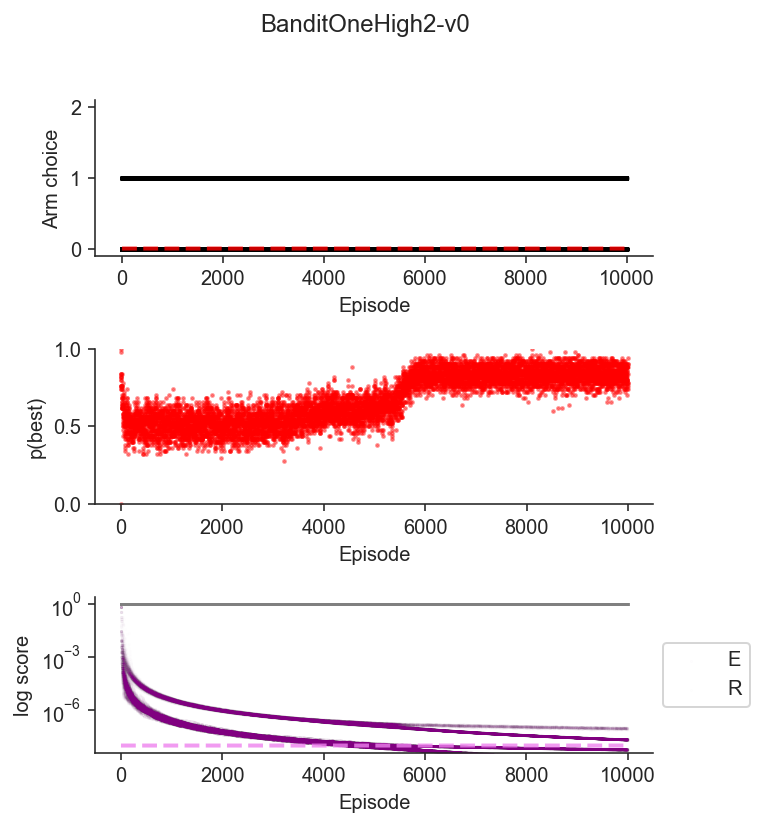

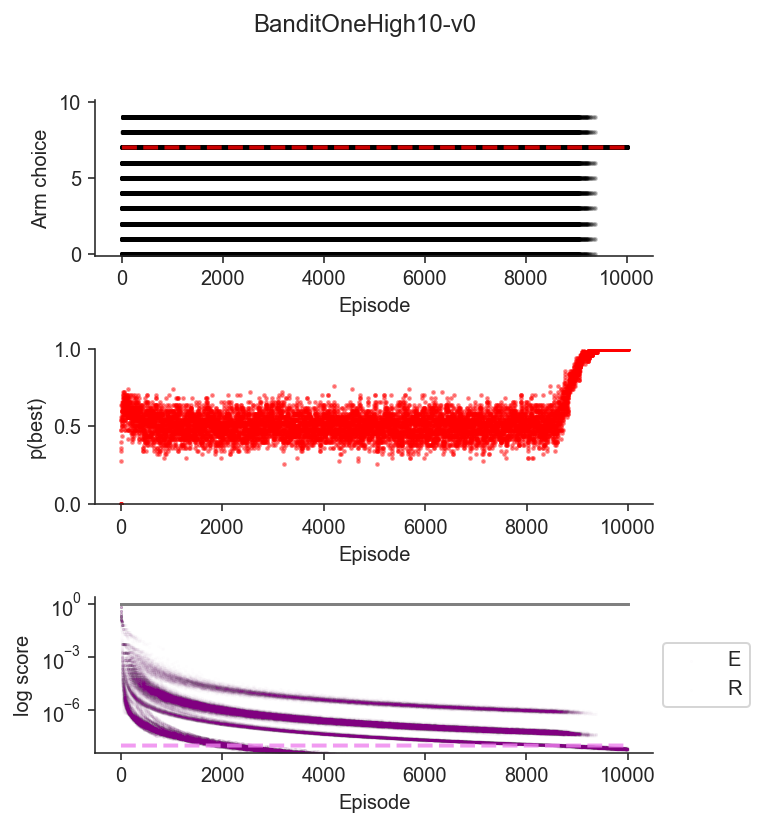

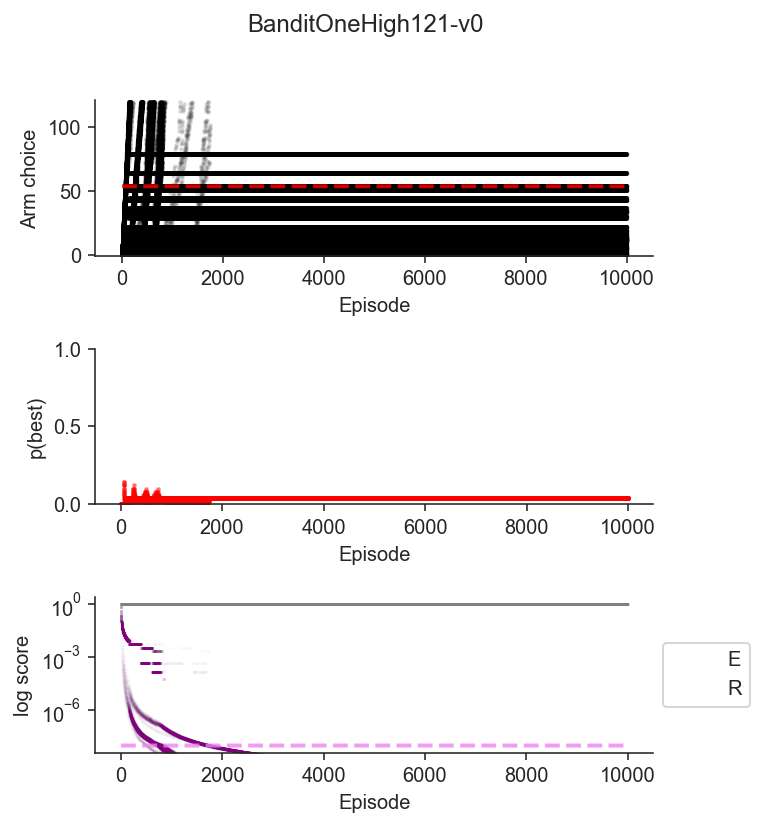

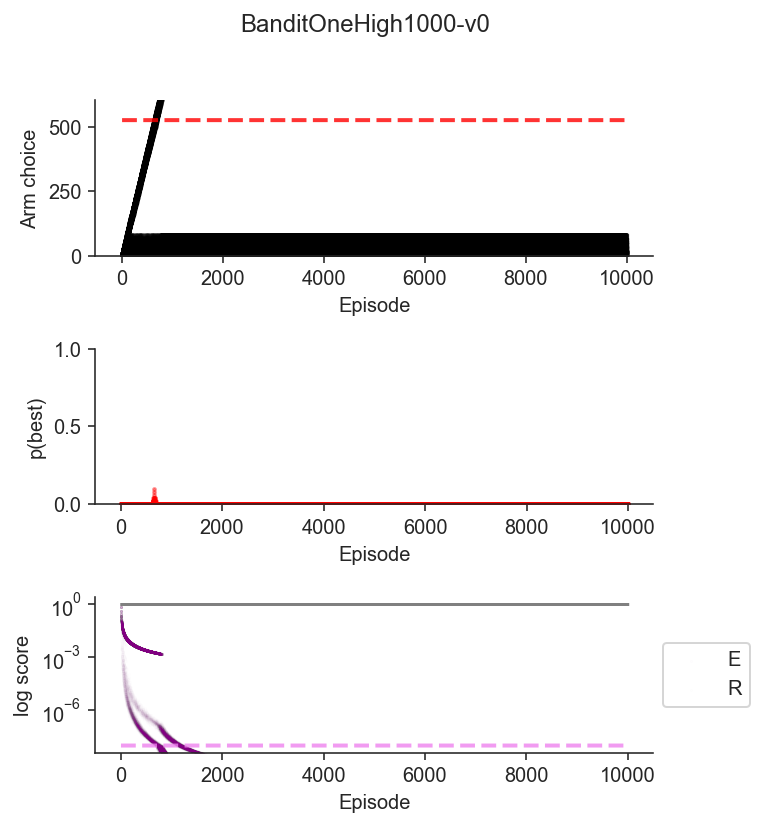

In [11]:
plot_names = env_names[0:4]
print(plot_names)

plot_env_performance(plot_names)

## Sparse

['BanditHardAndSparse2-v0', 'BanditHardAndSparse10-v0', 'BanditHardAndSparse121-v0', 'BanditHardAndSparse1000-v0']


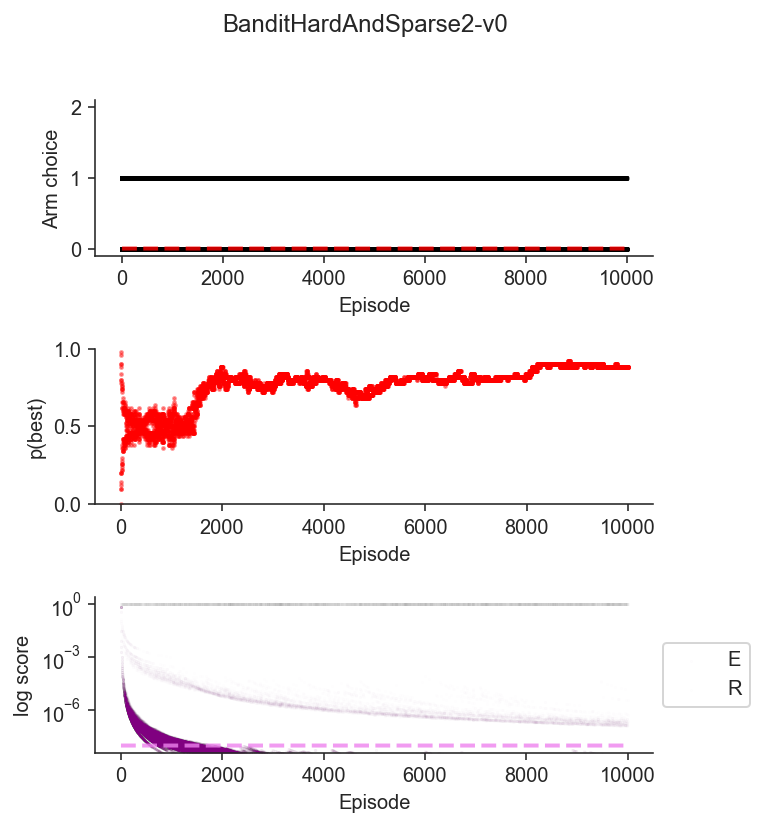

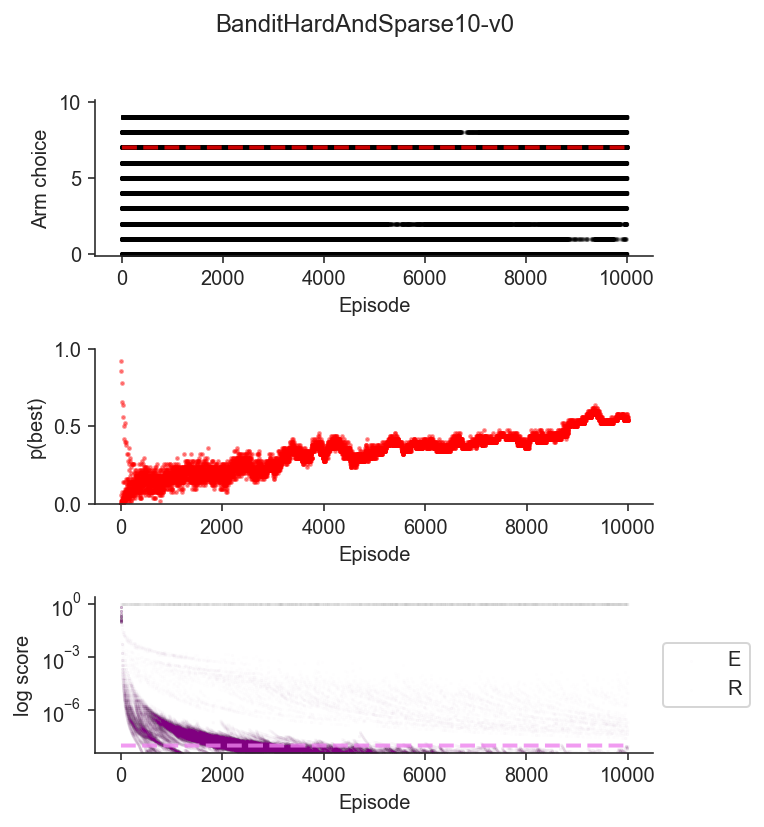

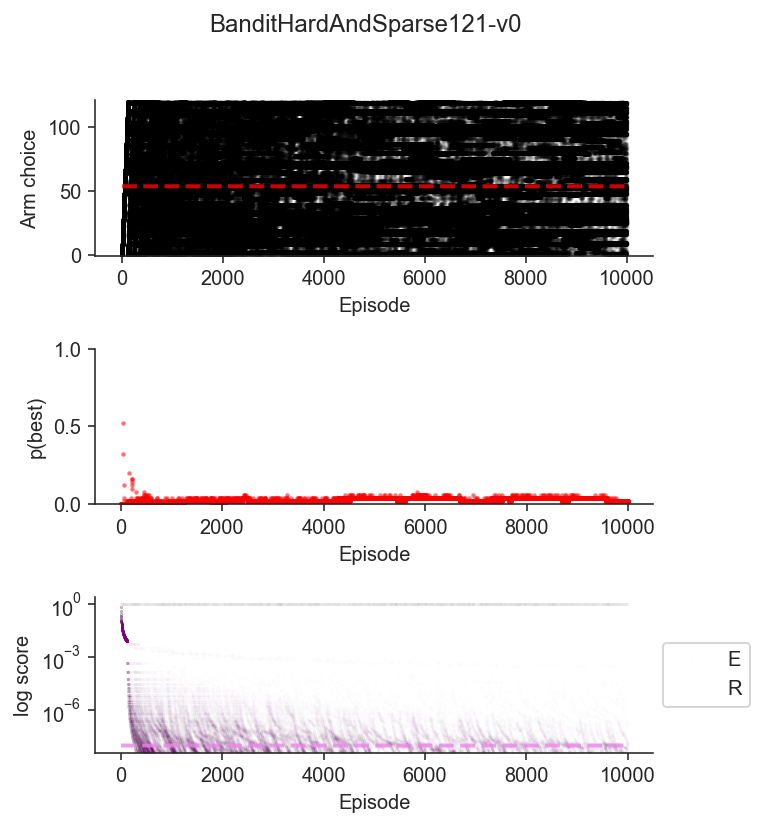

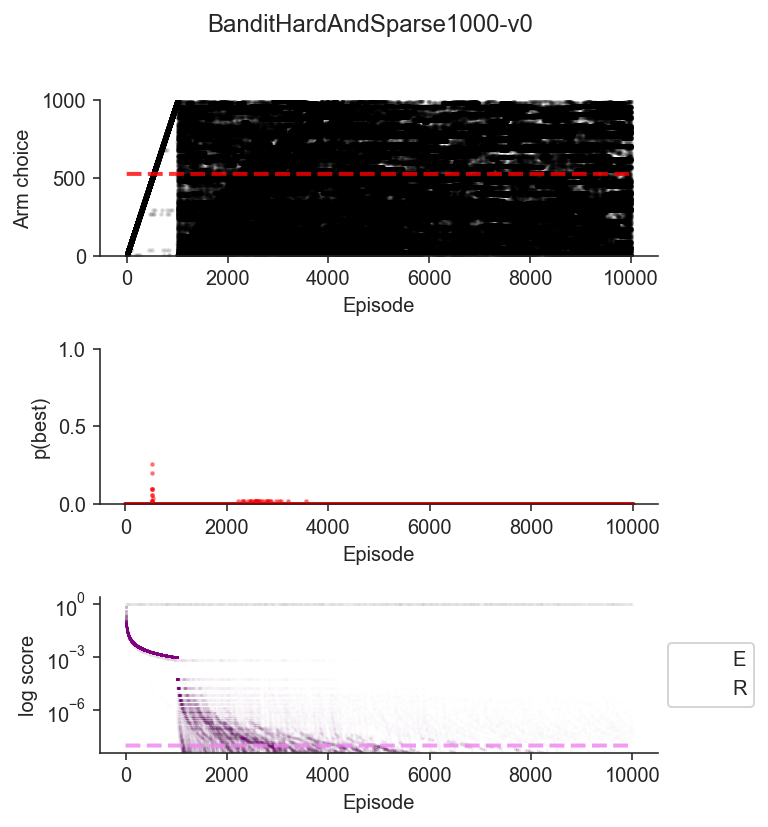

In [12]:
plot_names = env_names[4:8]
print(plot_names)

plot_env_performance(plot_names)

# Performance summary

For all bandits.

In [34]:
# # For all bandits plot total reward, 
# # with a line added to indicate 
# # the max. exp. total value

# # Convert to df
# df_total_R = None

# sns.boxplot(x="env", y="total", data=df_total_R, palette="Set2")
# sns.swarmplot(x="env", y="total", data=df_total_R, color=".25")
# _ = sns.despine()

In [33]:
# # For all bandits plot avg p_best for last 100 episodes

# # Convert to df
# df_p_pest = None

# sns.boxplot(x="env", y="p", data=df_p_pest, palette="Set2")
# sns.swarmplot(x="env", y="p", data=df_p_pest, color=".25")

# _ = sns.despine()